In [670]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

In [671]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [672]:
df.shape

(1460, 81)

In [673]:
a = df.isna().sum().reset_index(name="count")
a = a[a["count"] >= 100]

In [674]:
for i in a["index"]:
  df.drop(i, axis=1, inplace=True)
  df_test.drop(i, axis=1, inplace=True)

In [675]:
df.shape

(1460, 74)

In [676]:
df = df.drop("Id", axis=1)
target = df["SalePrice"]
df = df.drop("SalePrice", axis=1)
id_test = df_test["Id"]
df_test = df_test.drop("Id", axis=1)

In [677]:
df_numeric = df.select_dtypes("number")
df_numeric_test = df_test.select_dtypes("number")

In [678]:
def clip_data(df1,df2, variable):
  df2.iloc[:,variable] = df2.iloc[:,variable].clip(lower=df1.iloc[:,variable].min(), upper=df1.iloc[:,variable].max())
  return None

In [679]:
df_numeric.shape

(1460, 35)

In [680]:
for i in range(df_numeric.columns.size):
  clip_data(df_numeric,df_numeric_test,i)

In [681]:
def bin_the_data(df1,df2, variable):
  number_of_bins = int(np.ceil((df1.iloc[:,0].max()-df1.iloc[:,0].min())/df1.iloc[:,0].nunique()))
  labels_ = np.arange(number_of_bins)
  df1.iloc[:,variable] = pd.cut(df1.iloc[:,variable], bins=number_of_bins, labels=labels_)
  df2.iloc[:,variable] = pd.cut(df2.iloc[:,variable], bins=number_of_bins, labels=labels_)
  return None

In [682]:
for i in range(df_numeric.columns.size):
  bin_the_data(df_numeric,df_numeric_test,i)

<ipython-input-681-32fae2c7a7c9>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       2
1       0
2       2
3       3
4       2
       ..
1455    2
1456    0
1457    3
1458    0
1459    0
Name: MSSubClass, Length: 1460, dtype: category
Categories (12, int64): [0 < 1 < 2 < 3 ... 8 < 9 < 10 < 11]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[:,variable] = pd.cut(df1.iloc[:,variable], bins=number_of_bins, labels=labels_)
<ipython-input-681-32fae2c7a7c9>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0
1       0
2       2
3       2
4       7
       ..
1454    9
1455    9
1456    0
1457    4
1458    2
Name: MSSubClass, Length: 1459, dtype: category
Categories (12, int64): [0 < 1 < 2 < 3 ... 8 < 9 < 10 < 11]' has dtype incompatible with int64, please explicitly cast to a compatible dt

In [685]:
df_categorical = df.select_dtypes("object")
df_categorical_test = df_test.select_dtypes("object")

In [686]:
def label_encoder(val):
    if pd.isna(val):
        return np.nan
    elif val in mapping:
        return mapping[val]
    else:
        return max

In [687]:
def mapper(df1, variable, mapping, count):
  for i in df_categorical.iloc[:,variable].unique():
    mapping[i] = count
    count += 1
  return (mapping, count)

In [688]:
for i in range(df_categorical.columns.size):
  mapping = {}
  count = 0
  mapping, count = mapper(df_categorical, i, mapping, count)
  df_categorical.iloc[:,i] = df_categorical.iloc[:,i].apply(label_encoder)
  df_categorical_test.iloc[:,i] = df_categorical_test.iloc[:,i].apply(label_encoder)

In [691]:
df = pd.concat([df_numeric, df_categorical], axis=1)
df_test = pd.concat([df_numeric_test, df_categorical_test], axis=1)

In [692]:
imputer = KNNImputer(n_neighbors=5)
imputer.fit(df)
cols = df.columns
df = imputer.transform(df)
df = pd.DataFrame(df, columns=cols)
df_test = imputer.transform(df_test)
df_test = pd.DataFrame(df_test, columns=cols)

In [694]:
df.shape

(1460, 72)

In [703]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [725]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': np.arange(100, 400, 50),
    'max_features': ['sqrt', 'log2', None],
    'max_depth': np.arange(5, 105, 10),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 10),
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=200, cv=6, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

Fitting 6 folds for each of 200 candidates, totalling 1200 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=6, estimator=RandomForestRegressor(random_state=42),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95]),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([100, 150, 200, 250, 300, 350])},
                   random_state=42, verbose=2)

In [726]:
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'n_estimators': 350, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 85, 'bootstrap': False}


In [727]:
import matplotlib.pyplot as plt
import seaborn as sns

In [728]:
best_model = random_search.best_estimator_

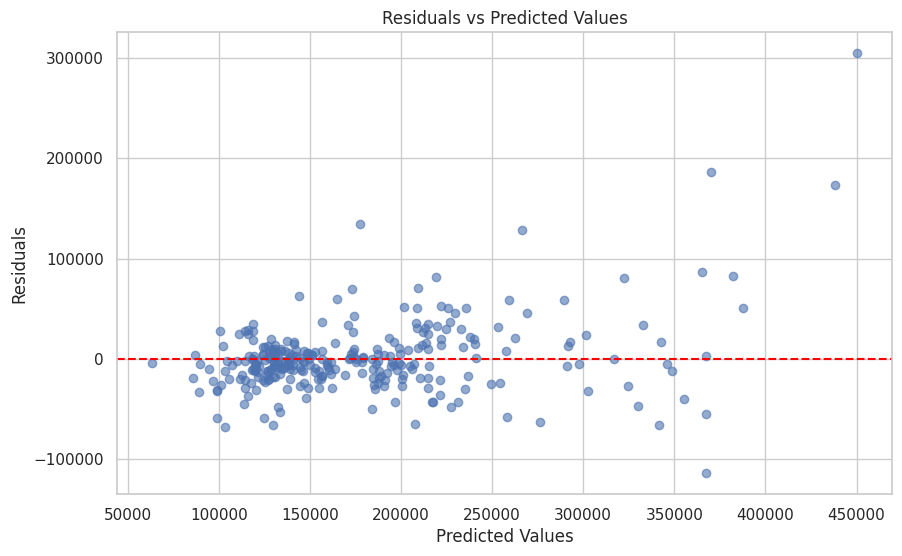

In [729]:
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


In [730]:
f_iloc = 0
with open("submission.csv", 'w') as file:
  for i in id:
    row = df_test.iloc[[f_iloc]]
    a = best_model.predict(row)
    if a.item() >0:
      to_write = f"{i},{a[0]}\n"
    else:
      to_write = f"{i},{10000}\n"
    file.write(to_write)
    f_iloc += 1